# **Imports**

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install pyg-lib -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

import requests
import pandas as pd
import io
import gzip
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.models import InnerProductDecoder, VGAE
from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops
import os
from torch.optim import Adam
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn.models import Node2Vec

!pip freeze > requirements.txt

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 6.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00


# **Data acquisition**

In [2]:
# Define the URL for the data
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Extract the content from the response
    content = response.content

    # Decompress the content using gzip
    with gzip.open(io.BytesIO(content), 'rt') as f:
        # Read the data into a Pandas DataFrame
        df = pd.read_csv(f, sep=" ", header=None, names=["source", "target"])

else:
    print("Failed to download the data. Status code:", response.status_code)

# **Data cleansing**

In [3]:
# Remove duplicate edges and self-edges
condition = df['source'] > df['target']
df.loc[condition, ['source', 'target']] = (df.loc[condition, ['target', 'source']].values)
df = df.drop_duplicates()
df = df[df['source'] != df['target']]

# **Data preparation**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
learning_rate = 0.01
num_features = 128
epoch = 100
hidden_channels = 32
out_channels = 16

# Generating node feature matrix using node2vec
edge_index = torch.tensor(df[['source', 'target']].values.T, dtype=torch.long)
n2v_model = Node2Vec(edge_index = edge_index, embedding_dim = num_features, walk_length = 80, context_size = 10, walks_per_node = 10, sparse = True)
data = Data(x=n2v_model.forward(), edge_index=edge_index)

# Splitting data into train, test and validation datasets
all_edge_index = data.edge_index.to(device)
all_edge_x = data.x.to(device)
data = train_test_split_edges(data, 0.05, 0.1).to(device)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


# **Model**

In [5]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.gcn_shared = GCNConv(in_channels, hidden_channels)
        self.gcn_mu = GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar


class DeepVGAE(VGAE):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(DeepVGAE, self).__init__(encoder=GCNEncoder(in_channels, hidden_channels, out_channels), decoder=InnerProductDecoder())

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        adj_pred = self.decoder.forward_all(z)
        return adj_pred

    def loss(self, x, pos_edge_index, all_edge_index):
        z = self.encode(x, pos_edge_index)

        pos_loss = -torch.log(self.decoder(z, pos_edge_index, sigmoid=True) + 1e-15).mean()

        # Do not include self-loops in negative samples
        all_edge_index_tmp, _ = remove_self_loops(all_edge_index)
        all_edge_index_tmp, _ = add_self_loops(all_edge_index_tmp)

        neg_edge_index = negative_sampling(all_edge_index_tmp, z.size(0), pos_edge_index.size(1))
        neg_loss = -torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + 1e-15).mean()

        kl_loss = 1 / x.size(0) * self.kl_loss()

        return pos_loss + neg_loss + kl_loss

    def single_test(self, x, train_pos_edge_index, test_pos_edge_index, test_neg_edge_index):
        with torch.no_grad():
            z = self.encode(x, train_pos_edge_index)
        roc_auc_score, average_precision_score = self.test(z, test_pos_edge_index, test_neg_edge_index)
        return roc_auc_score, average_precision_score

# **Training the model**

In [6]:
model = DeepVGAE(num_features, hidden_channels, out_channels).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(epoch):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(data.x, data.train_pos_edge_index, all_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        roc_auc, ap = model.single_test(data.x, data.train_pos_edge_index, data.test_pos_edge_index, data.test_neg_edge_index)
        print("Epoch {} - Loss: {}, ROC_AUC: {}, Precision: {}".format(epoch, loss.cpu().item(), roc_auc, ap))

Epoch 0 - Loss: 3.924163818359375, ROC_AUC: 0.6216437533458173, Precision: 0.6050489138251236
Epoch 10 - Loss: 1.6789708137512207, ROC_AUC: 0.8545113156371913, Precision: 0.8531428814885837
Epoch 20 - Loss: 1.0720899105072021, ROC_AUC: 0.9153736892807016, Precision: 0.9223609925239534
Epoch 30 - Loss: 0.9463952779769897, ROC_AUC: 0.9479439222358478, Precision: 0.9534321881881312
Epoch 40 - Loss: 0.9039803743362427, ROC_AUC: 0.9635856828352539, Precision: 0.9675877484824094
Epoch 50 - Loss: 0.8764693140983582, ROC_AUC: 0.972062768210537, Precision: 0.9748295972379923
Epoch 60 - Loss: 0.8628825545310974, ROC_AUC: 0.9767731985563322, Precision: 0.9789714756479917
Epoch 70 - Loss: 0.8531568646430969, ROC_AUC: 0.9794014808518569, Precision: 0.9812859756241361
Epoch 80 - Loss: 0.8440874218940735, ROC_AUC: 0.9813807839388796, Precision: 0.9829957876245667
Epoch 90 - Loss: 0.8338752388954163, ROC_AUC: 0.9832693044434304, Precision: 0.9845983666216247


# **Creating and cleansing output**

In [7]:
# Predicting adjacency matrix containing edge probabilities
final_edge_index = model.forward(all_edge_x, all_edge_index)

# Creating a pandas dataframe from the adjacency matrix
pred_adj_mat = final_edge_index
pred_adj_mat_numpy = pred_adj_mat.cpu().detach().numpy()
G_pred = nx.from_numpy_array(pred_adj_mat_numpy)
df_pred = nx.to_pandas_edgelist(G_pred)

# Deleting duplicate edges and self-edges
condition = df_pred['source'] > df_pred['target']
df_pred.loc[condition, ['source', 'target']] = (df_pred.loc[condition, ['target', 'source']].values)
df_pred = df_pred.drop_duplicates()
df_pred = df_pred[df_pred['source'] != df_pred['target']]

# **Retrieving predictions for a single node**

      source  target    weight     _merge
0     3987.0  4007.0  1.000000  left_only
1     3987.0  4016.0  1.000000  left_only
2     3987.0  4025.0  1.000000  left_only
3     3987.0  4015.0  1.000000  left_only
4     3987.0  4008.0  0.999997  left_only
...      ...     ...       ...        ...
4033  3262.0  3987.0  0.000057  left_only
4034  2364.0  3987.0  0.000053  left_only
4035  2657.0  3987.0  0.000039  left_only
4036  2648.0  3987.0  0.000028  left_only
4037  3830.0  3987.0  0.000006  left_only

[4036 rows x 4 columns]


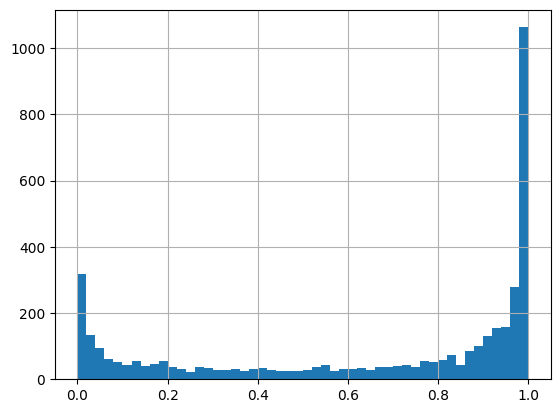

In [8]:
# Retrieving edges of the node with name: index
index = 3987
condition = df_pred['source'] == index
predicted_edges = df_pred.loc[condition, df_pred.columns]
condition = df_pred['target'] == index
predicted_edges = pd.concat([predicted_edges, df_pred.loc[condition, df_pred.columns]])

# Sorting edges by probability
predicted_edges = predicted_edges.sort_values(by=['weight'], ascending=False)

# Dropping every edge contained in the input graph thus retaining new edges only
predicted_edges = predicted_edges.merge(df, indicator=True, how='outer')
print(predicted_edges[predicted_edges['_merge'] == 'left_only'])

# Displaying histogram of edge probabilities of node: index
hist = predicted_edges['weight'].hist(bins=50)